In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import plot_importance as xplot
from lightgbm import plot_importance as lplot
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [7]:
data_dir = os.getcwd()

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 1. 데이터 불러오기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## 2. EDA

In [5]:
train.isnull().sum() # 결측값 없음

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [6]:
train.shape[0],len(train['id'].unique()) # 중복값 없음

(15035, 15035)

In [7]:
# id는 필요 없으므로 제거
del train['id']
del test['id']

### date 처리

In [8]:
# 년, 월, 일만 나와있으므로
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

In [9]:
del train['date']

### 수치형 범주형 나누기

In [10]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'day'],
      dtype='object')

In [11]:
# 컬럼별 유니크 값의 개수
for cols in train.columns:
    print(cols, len(train[cols].unique()))

price 3263
bedrooms 11
bathrooms 29
sqft_living 863
sqft_lot 7678
floors 6
waterfront 2
view 5
condition 5
grade 12
sqft_above 789
sqft_basement 271
yr_built 116
yr_renovated 65
zipcode 70
lat 4692
long 716
sqft_living15 682
sqft_lot15 6958
year 2
month 12
day 31


In [12]:
# 유니크 값이 적은 컬럼들을 category로 변환
train = train.astype('float64')
train = train.astype({'bedrooms':'int', 'floors':'int','waterfront':'int',
                      'view':'int', 'condition':'int', 'grade':'int','year':'int','month':'int'})
# train = train.astype({'bedrooms':'category', 'floors':'category','waterfront':'category',
#                       'view':'category', 'condition':'category', 'grade':'category','year':'category','month':'category'})

In [13]:
num_train = train.select_dtypes(include='float64')
cat_train = train.select_dtypes(exclude='float64')

In [14]:
print(num_train.columns)
print(cat_train.columns)

Index(['price', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'day'],
      dtype='object')
Index(['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'year', 'month'],
      dtype='object')


### 데이터 분포 확인

#### numeric

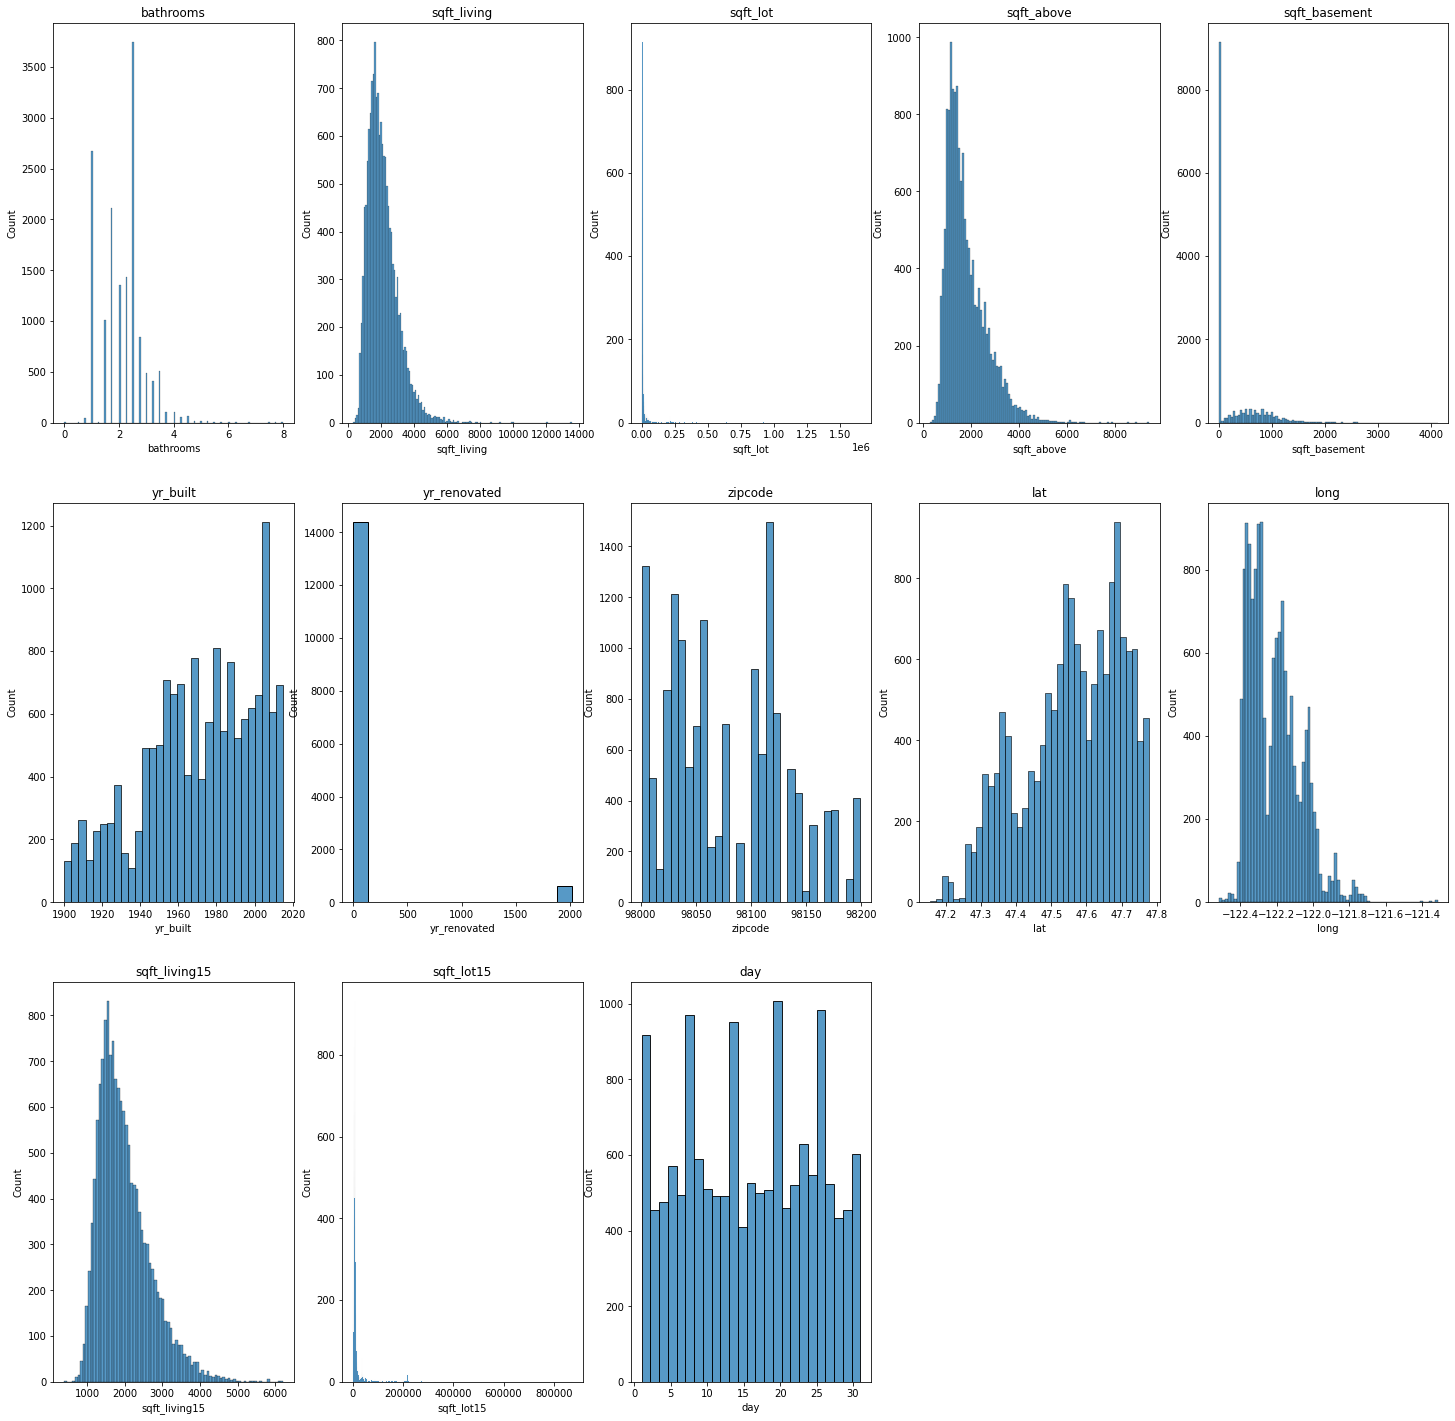

In [15]:
plt.figure(figsize=(25, 25))
for i in range(1,14) : #price를 뺀 나머지
    plt.subplot(3, 5, i)
    plt.title(num_train.columns[i])
    sns.histplot(train[num_train.columns[i]])

In [16]:
len(train[train['sqft_basement']==0]),train.shape[0]

(9143, 15035)

In [17]:
train['basement'] = np.where(train['sqft_basement']==0,0,1)
del train['sqft_basement']
train['basement']

0        0
1        0
2        0
3        0
4        0
        ..
15030    0
15031    1
15032    0
15033    0
15034    0
Name: basement, Length: 15035, dtype: int64

sqft_living 은 sqft_basement + sqft_above이고 지하실의 면적이 0인(지하실 없는)집이 절반보다 많다. 따라서 basement의 유뮤로 바꿔준다.

In [18]:
len(train[train['yr_renovated']==0]),train.shape[0]

(14404, 15035)

재건축 년도가 0 (재건축 안된) 건물이 대부분이므로 재건축년도를 재건축 여부로 만든다.

In [19]:
train['renovated'] = np.where(train['yr_renovated']==0,0,1)
del train['yr_renovated']
train[train['renovated']==1]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,basement,renovated
26,696000.0,3,2.50,2300.0,3060.0,1,0,0,3,8,...,98115.0,47.6827,-122.310,1590.0,3264.0,2014,6,13.0,1,1
78,740500.0,3,3.50,4380.0,6350.0,2,0,0,3,8,...,98117.0,47.6981,-122.368,1830.0,6350.0,2014,11,21.0,1,1
149,1505000.0,5,3.00,3300.0,33474.0,1,0,3,3,9,...,98040.0,47.5673,-122.210,3836.0,20953.0,2015,2,21.0,1,1
160,655000.0,2,1.75,1450.0,15798.0,2,1,4,3,7,...,98166.0,47.4497,-122.375,2030.0,13193.0,2015,4,13.0,1,1
166,410000.0,4,1.00,1970.0,4740.0,1,0,0,3,7,...,98122.0,47.6136,-122.303,1510.0,4740.0,2015,3,20.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13626,257000.0,3,1.75,1397.0,18000.0,1,0,0,3,7,...,98092.0,47.3388,-122.166,1950.0,31294.0,2014,11,4.0,0,1
13641,451000.0,2,1.00,900.0,6000.0,1,0,0,3,7,...,98115.0,47.6855,-122.289,1460.0,4800.0,2014,7,12.0,0,1
13952,434900.0,3,2.00,1520.0,5040.0,2,0,0,3,7,...,98177.0,47.7770,-122.362,1860.0,8710.0,2014,9,4.0,0,1
14218,500012.0,4,2.50,2400.0,9612.0,1,0,0,3,8,...,98059.0,47.4799,-122.127,2430.0,5539.0,2015,2,25.0,1,1


sqft_living/sqft_lot해준 새로운 변수 생성, sqftliving/lot은 삭제해주고 치우쳐진 sqft_living15/lot15에 로그변환을 해준다.

또한 numeric features의 분포 모양이 제각각이므로 로그변환 또는 정규화를 해준다.

In [20]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

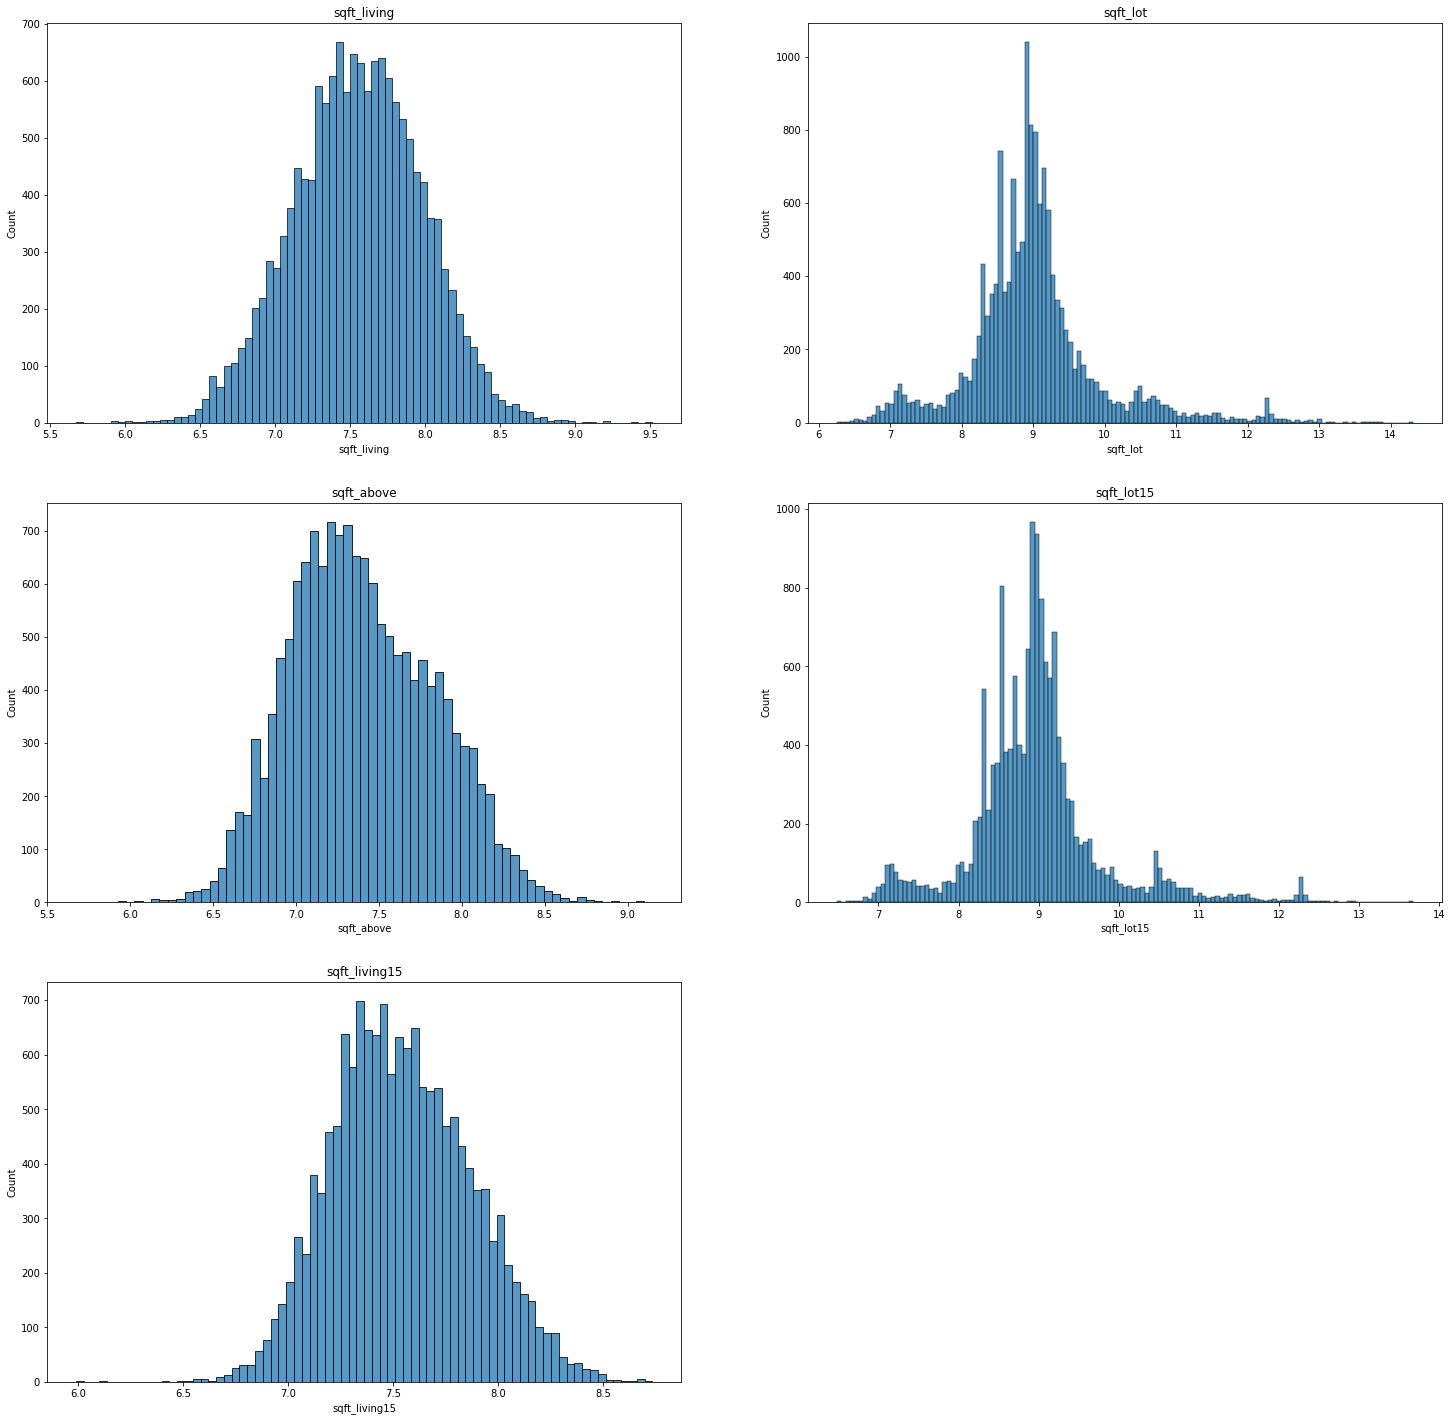

In [21]:
plt.figure(figsize=(25, 25))
for i in range(5) : #price를 뺀 나머지
    plt.subplot(3, 2, i+1)
    plt.title(skew_columns[i])
    sns.histplot(train[skew_columns[i]])

<AxesSubplot:xlabel='living/lot', ylabel='Count'>

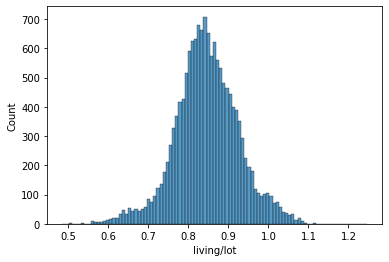

In [22]:
train['living/lot'] = train['sqft_living'] / train['sqft_lot']
sns.histplot(train['living/lot'])

생활공간/부지공간 해준 변수를 만들었다.

In [23]:
train.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors             int64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above       float64
yr_built         float64
zipcode          float64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
year               int64
month              int64
day              float64
basement           int64
renovated          int64
living/lot       float64
dtype: object

#### categorical

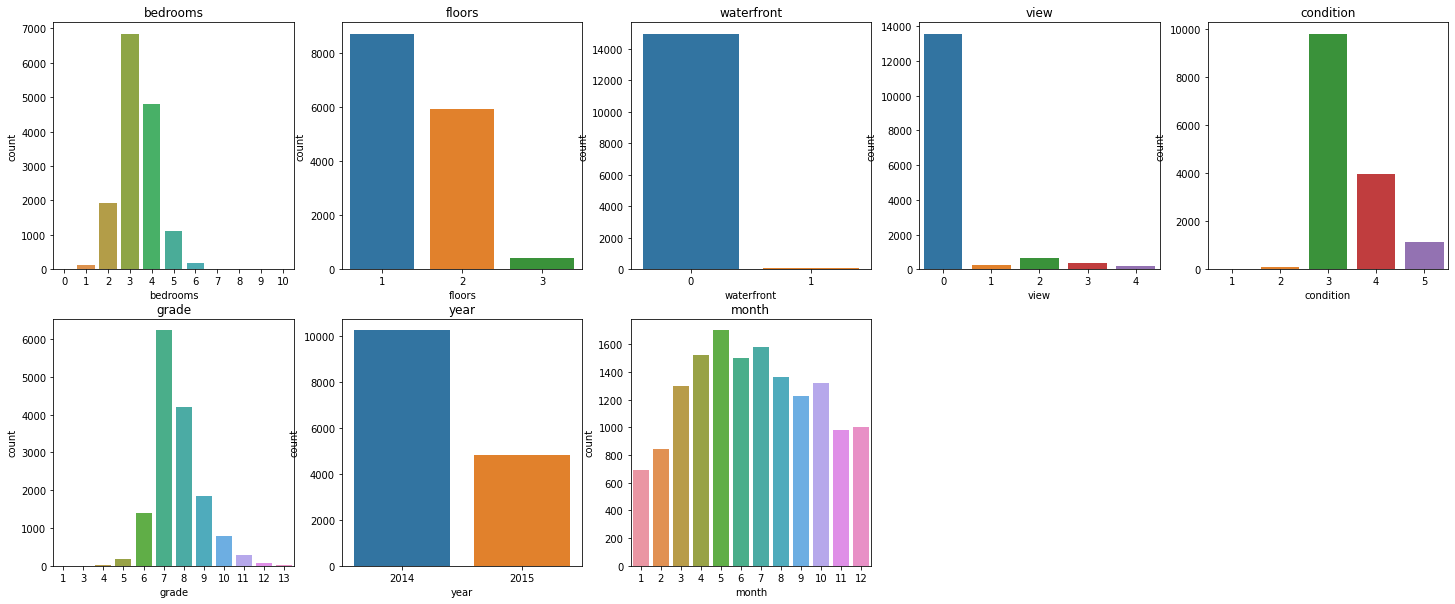

In [26]:
plt.figure(figsize=(25, 10))
for i in range(8) : 
    plt.subplot(2, 5, i+1)
    plt.title(cat_train.columns[i])
    sns.countplot(train[cat_train.columns[i]])

범주형 feature들에게는 몇몇을 제외하고 데이터 불균형이 심하게 나타난다. 일단 놔두고 모델링을 해본다.

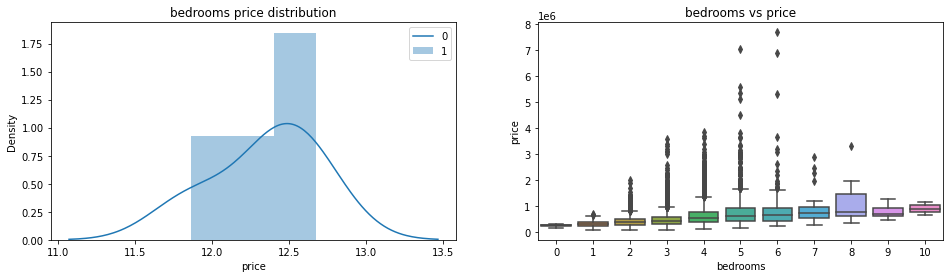

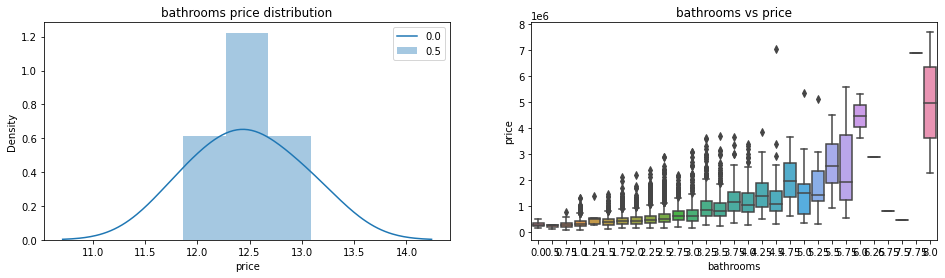

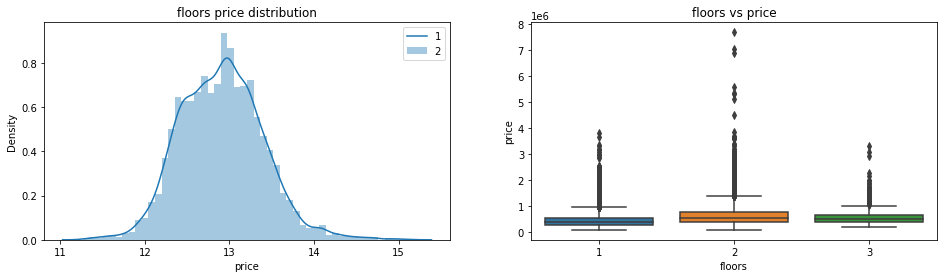

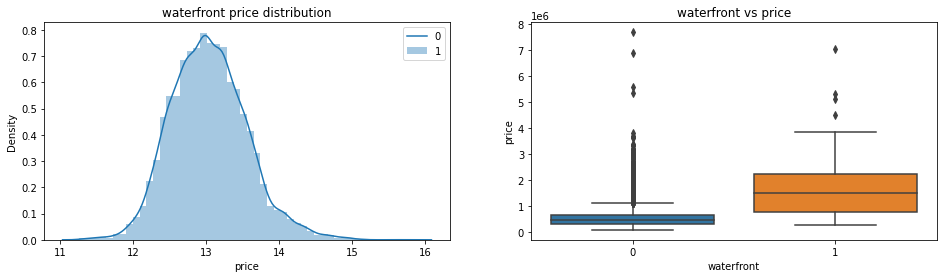

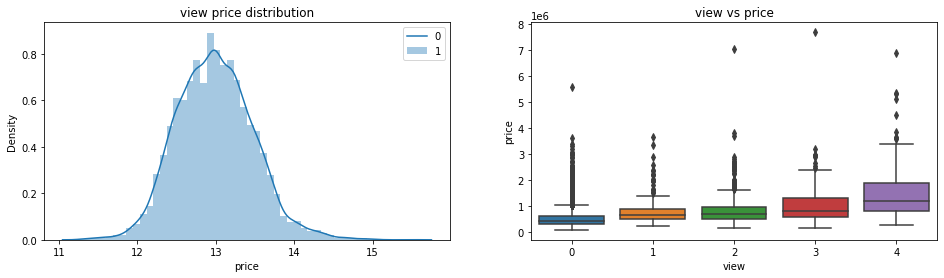

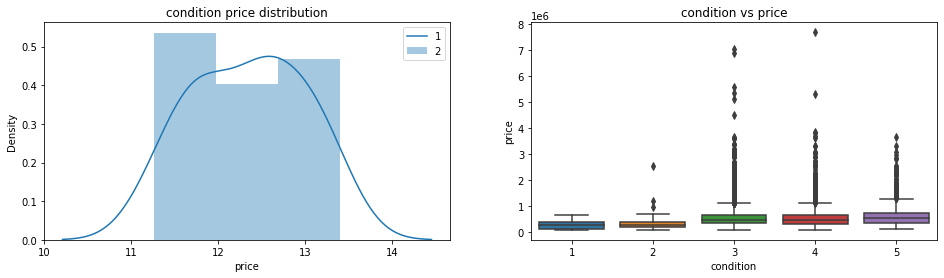

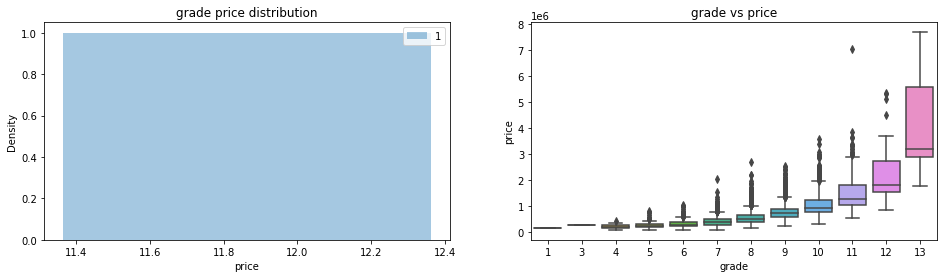

In [27]:
for col in ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']:
    target = 'price'
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    
    for c in sorted(train[col].unique()):
        sns.distplot(np.log1p(train.loc[train[col]==c, target]), ax=ax[0])
        ax[0].legend(sorted(train[col].unique()))
        ax[0].set_title(f'{col} {target} distribution')

        sns.boxplot(x=col, y=target, data=train, ax=ax[1])
        ax[1].set_title(f'{col} vs {target}')

        plt.show()

<AxesSubplot:>

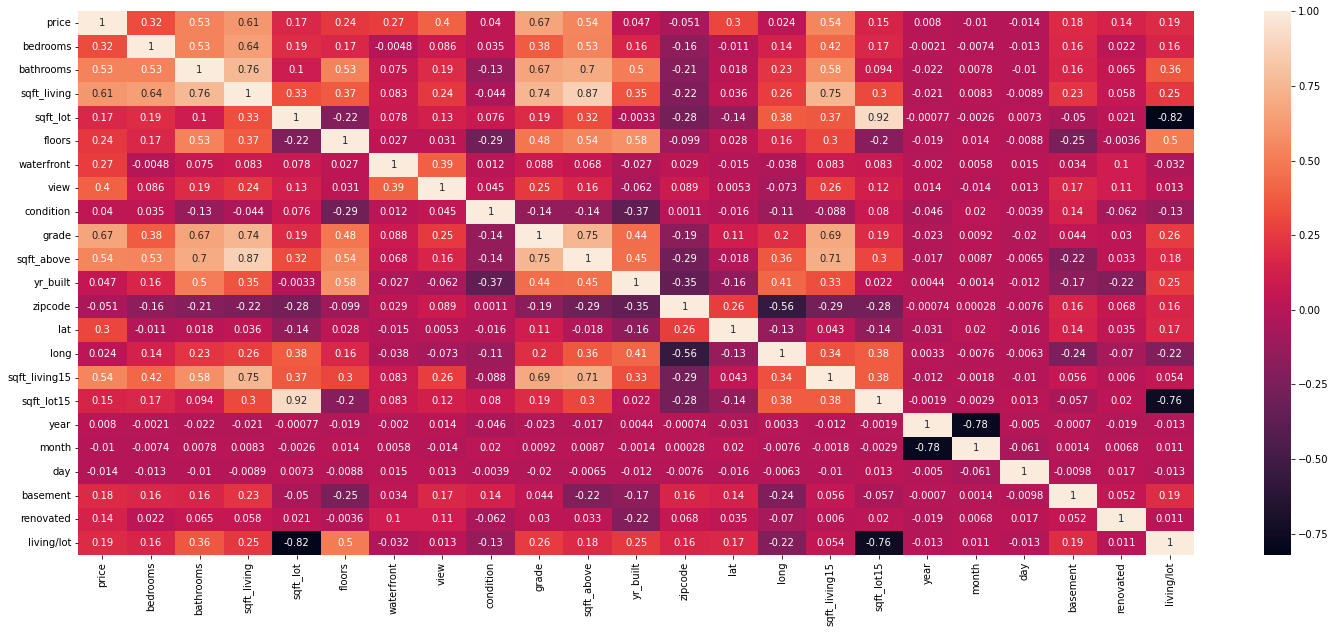

In [28]:
plt.figure(figsize=(25,10))
sns.heatmap(train.corr(), annot=True)

sqft_above 변수는 위에서 말했듯이 sqft_living - sqft_basement였으므로 sqft_living15와도 높은 상관관계를 가진다. 지상층의 면적이 넓을 수록 화장실이 많은것도 당연하다

#### 년도 , 월 처리

<AxesSubplot:xlabel='built', ylabel='Density'>

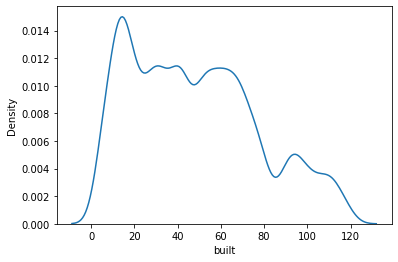

In [29]:
train['built'] = 2019 - train['yr_built']
sns.kdeplot(train['built'])

In [30]:
# 준공년도를 Construction Completion Date라고 한다. 년도를 구간을 나눠서 범주화
train['CCD'] = pd.cut(train['built'], bins=[0, 20, 40, 60, 120], labels=[1,2,3,4])

<AxesSubplot:xlabel='CCD', ylabel='count'>

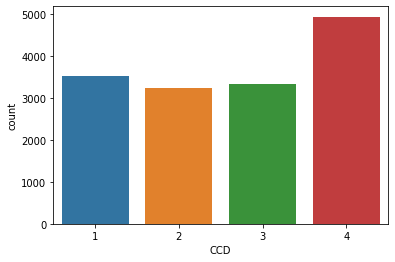

In [31]:
sns.countplot(train['CCD'])

<AxesSubplot:xlabel='CCD', ylabel='price'>

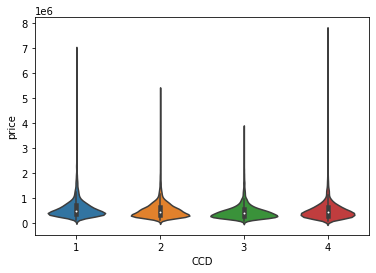

In [32]:
sns.violinplot(train['CCD'],train['price'])

#### month 변수 계절별로 보기

In [33]:
train['season'] = np.where((train['month'] >= 3) & (train['month'] < 6), 'spring',
                           (np.where((train['month'] >= 6) & (train['month'] < 9), 'summer',
                                     (np.where((train['month'] >= 9) & (train['month'] < 12),'fall', 'winter')))))

<AxesSubplot:xlabel='season', ylabel='count'>

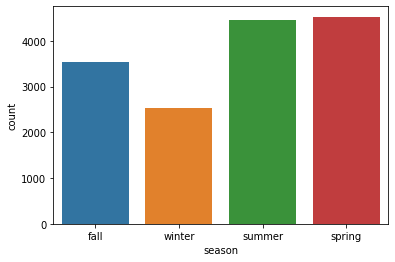

In [34]:
sns.countplot(train['season'])

<AxesSubplot:xlabel='season', ylabel='price'>

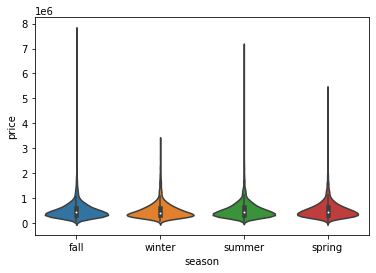

In [35]:
sns.violinplot(train['season'],train['price'])

#### zipcode 처리

In [36]:
data = train.astype({'zipcode':'str'})
data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

<AxesSubplot:xlabel='long', ylabel='lat'>

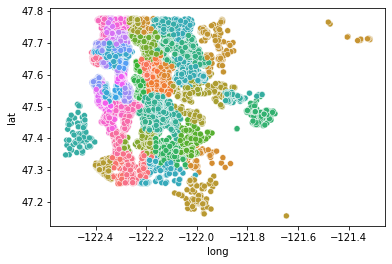

In [37]:
data['zipcode'] = 'z_' + data['zipcode']
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(data['zipcode'].unique()), data=data, legend=False)

<AxesSubplot:xlabel='long', ylabel='lat'>

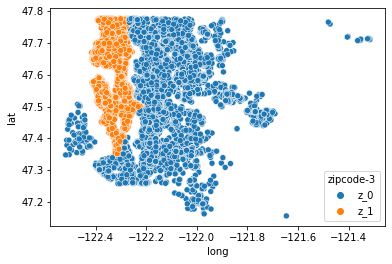

In [38]:
sns.scatterplot(x='long', y='lat', hue='zipcode-3', hue_order=np.sort(data['zipcode-3'].unique()), data=data)

<AxesSubplot:xlabel='long', ylabel='lat'>

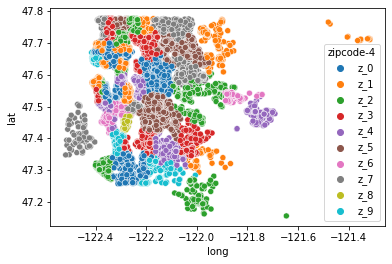

In [39]:
sns.scatterplot(x='long', y='lat', hue='zipcode-4', hue_order=np.sort(data['zipcode-4'].unique()), data=data)

In [375]:
pd.qcut(df['lat'], [0.,.25,.5,.75,1])

0        (-0.088, 0.0112]
1          (0.118, 0.217]
2         (0.0112, 0.118]
3        (-0.406, -0.088]
4        (-0.406, -0.088]
               ...       
15030    (-0.088, 0.0112]
15031    (-0.088, 0.0112]
15032      (0.118, 0.217]
15033    (-0.088, 0.0112]
15034     (0.0112, 0.118]
Name: lat, Length: 15035, dtype: category
Categories (4, interval[float64, right]): [(-0.406, -0.088] < (-0.088, 0.0112] < (0.0112, 0.118] < (0.118, 0.217]]

<AxesSubplot:xlabel='zipcode-35', ylabel='price'>

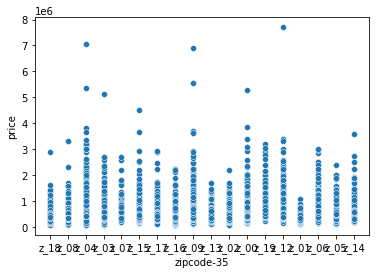

In [40]:
sns.scatterplot(data['zipcode-35'],data['price'])

zip코드를 그냥 쓰기보다는 앞의두글자가 98로 같기 때문에 뒷자리로 지리가 어느정도 구분되는것을 볼 수 있다. zipcode-4를 써보기로 했다.

### 실험 Log

Log 읽는법   
빈 로그 딕셔너리에 원 데이터의 Feature의 이름들을 origin으로 넣어놨다. experiment함수 실행결과   
{'+: col1, col2,  -: col3, col4'} 이런식의 로그가 나온다. + 에 있는 컬럼명은 새로 추가가 된 컬럼이고 -에 있는 컬럼명은 원 데이터에서 빠진 컬럼명이다.

In [6]:
def haversine_array(lat1, lng1, lat2, lng2): 
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) 
    AVG_EARTH_RADIUS = 6371 # in km 
    lat = lat2 - lat1 
    lng = lng2 - lng1 
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2 
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)) 
    return h

In [335]:
def label_encode(df1,df2):
    transform_dict = {}
    cat_cols = df1.select_dtypes(exclude = np.number).columns
    for col in cat_cols:
        cats = pd.Categorical(df1[col]).categories
        d = {}
        for i, cat in enumerate(cats):
            d[cat] = i
        transform_dict[col] = d

    inverse_transform_dict = {}
    for col, d in transform_dict.items():
        inverse_transform_dict[col] = {v:k for k, v in d.items()}
    df1 = df1.replace(transform_dict)
    df2 = df2.replace(transform_dict)
    return df1, df2, transform_dict, inverse_transform_dict

In [328]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [329]:
def compare(origin, df):
    a = set(list(origin))
    b = set(list(df.columns))
    deleted = a-b
    added = b-a
    state = f'''+:{','.join(added)} -:{','.join(deleted)}'''
    print(state)
    return state

In [330]:
random_state = 42
log = {}

In [356]:
def preprocess(df):
    del df['id']

    df['month'] = pd.to_datetime(df['date']).dt.month
    df['day'] = pd.to_datetime(df['date']).dt.day
    coord = df[['long', 'lat']]
    x1,y1 = df['lat'].median(), df['long'].median()
    df['max_dist'] = np.log1p(haversine_array(df['lat'],df['long'],x1,y1))
    df['basement'] = np.where(df['sqft_basement']==0,0,1)
    
    df['zipcode'] = df['zipcode'].astype('str')
    df['zipcode-5'] = 'z_' + df['zipcode'].str[4:5]
    df['zipcode'] = df['zipcode'].astype('int64')
    
    df['rooms'] = df['bedrooms'] + df['bathrooms']
    df['water2'] = np.where(df['waterfront']==1,3,1)
    df['v2'] = df['view'] * df['water2']
    
    df['sqft_above'] = np.log1p(df['sqft_above'])
    df['long'] = df['long'] - np.mean(df['long'])
    df['lat'] = df['lat'] - np.mean(df['lat'])
    
    #  grade pooling
    df['grade2'] = np.where(df['grade'] < 7, 1,
                           (np.where(df['grade'] > 8, 3, 2)))
    df['grade3'] = df['grade2'] + df['condition']
    df['grade4'] = df['v2'] + df['grade3']
    
    df['lat2'] = pd.qcut(df['lat'], 10, labels=False)
    df['long2'] = pd.qcut(df['long'], 10, labels=False)
    df['area'] = df['lat2'] + df['long2']
    #del df['lat2'], df['long2']
    
    y = df['price']
    
    del df['price']
    del df['date']
    del df['sqft_basement']
    del df['sqft_living15'],df['sqft_lot15']
    del df['sqft_living'],df['sqft_lot']
    del df['bedrooms'], df['bathrooms']
    del df['waterfront']
    del df['grade3']
    
    return df, y

def experiment(df):
    origin = df.columns
    X,y = preprocess(df)
    print('preprocessing')
    X,_,_,_ = label_encode(X,test)
    y = np.log1p(y)

    print('training')
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X_train, y_train)
    
    print('predicting')
    y_pred = model.predict(X_test)
    
    print('estimating')
    score = rmse(y_test, y_pred)
    state = compare(origin, X)
    log[state] = score
    return log

In [191]:
# df, y = preprocess(pd.read_csv(train_data_path))
# df.columns

Index(['floors', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'month', 'day', 'max_dist',
       'basement', 'zipcode-5', 'rooms', 'v2', 'water2'],
      dtype='object')

In [183]:
#experiment(pd.read_csv(train_data_path))
sorted(log.items(), key = lambda item: item[1])

[('+:day,month -:id,date,price', 140465.49496641007),
 ('+:day,year -:id,date,price', 140465.49496641007),
 ('+:month,year -:id,date,price', 140465.49496641007),
 ('+:year -:id,date,price', 140481.08171942024),
 ('+:month -:id,date,price', 140481.08171942024),
 ('+:day,month,year -:id,date,price', 140610.79034560066),
 ('+:day,month,year -:id,price', 140985.59095121673),
 ('+:day -:id,date,price', 141052.15374480764)]

id는 고유값이고, price는 target이기 때문에 제거, date 컬럼 실험 결과 day, month, year를 만들고 date 유무를 비교했을 때 date가 없는 실험이 성능이 좋았고 3개중에 두개를 선택했을때가 가장 성능이 잘 나오고 같게 나왔다. 따라서 두개의 정보만 있는 year를 버리고 day, month를 가지고 가겠다.

In [193]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:day,month,max_dist -:id,date,price


{'+:day,month,year -:id,price': 140985.59095121673,
 '+:day,month,year -:id,date,price': 140610.79034560066,
 '+:day,month -:id,date,price': 140465.49496641007,
 '+:day,year -:id,date,price': 140465.49496641007,
 '+:month,year -:id,date,price': 140465.49496641007,
 '+:year -:id,date,price': 140481.08171942024,
 '+:month -:id,date,price': 140481.08171942024,
 '+:day -:id,date,price': 141052.15374480764,
 '+:day,month,season -:id,date,price': 140701.98557035226,
 '+:day,month,max_dist -:id,date,price': 138755.1624974665}

month를 계절별로 나눠서 실험해봤지만 성능이 좋아지지 않았다.
또한 데이터의 위도경도의 중심부(전체 위도의 median, 전체 경도의 median)로부터의 거리를 재서 컬럼으로 넣어준 경우가 가장 점수가 좋기 때문에 max_dist라는 feature를 추가했다.

In [202]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:day,month,max_dist,living/lot15 -:id,date,price


{'+:day,month,year -:id,price': 140985.59095121673,
 '+:day,month,year -:id,date,price': 140610.79034560066,
 '+:day,month -:id,date,price': 140465.49496641007,
 '+:day,year -:id,date,price': 140465.49496641007,
 '+:month,year -:id,date,price': 140465.49496641007,
 '+:year -:id,date,price': 140481.08171942024,
 '+:month -:id,date,price': 140481.08171942024,
 '+:day -:id,date,price': 141052.15374480764,
 '+:day,month,season -:id,date,price': 140701.98557035226,
 '+:day,month,max_dist -:id,date,price': 138755.1624974665,
 '+:day,month,max_dist,living/lot -:id,date,price': 138938.06549558998,
 '+:max_dist,day,living/lot15,living/lot,month -:id,date,price': 140131.61486656286,
 '+:day,month,max_dist,living/lot15 -:id,date,price': 139345.21025971178}

생활/부지 -> 부지대비 생활공간이 얼마나 넓나 하는 변수를 만들어봤지만 하나씩만 쓰거나 둘다 써도 성능이 좋아지지 않아서 사용X

In [209]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:day,month,max_dist -:id,date,price


{'+:day,month,year -:id,price': 140985.59095121673,
 '+:day,month,year -:id,date,price': 140610.79034560066,
 '+:day,month -:id,date,price': 140465.49496641007,
 '+:day,year -:id,date,price': 140465.49496641007,
 '+:month,year -:id,date,price': 140465.49496641007,
 '+:year -:id,date,price': 140481.08171942024,
 '+:month -:id,date,price': 140481.08171942024,
 '+:day -:id,date,price': 141052.15374480764,
 '+:day,month,season -:id,date,price': 140701.98557035226,
 '+:day,month,max_dist -:id,date,price': 139067.66783884523,
 '+:day,month,max_dist,living/lot -:id,date,price': 138938.06549558998,
 '+:max_dist,day,living/lot15,living/lot,month -:id,date,price': 140131.61486656286,
 '+:day,month,max_dist,living/lot15 -:id,date,price': 139345.21025971178}

max_dist를 median 대신 mean 해줬을때 성능이 더 안좋아서 median으로 유지

In [218]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:day,month,max_dist,basement -:id,date,price,sqft_basement


{'+:day,month,year -:id,price': 140985.59095121673,
 '+:day,month,year -:id,date,price': 140610.79034560066,
 '+:day,month -:id,date,price': 140465.49496641007,
 '+:day,year -:id,date,price': 140465.49496641007,
 '+:month,year -:id,date,price': 140465.49496641007,
 '+:year -:id,date,price': 140481.08171942024,
 '+:month -:id,date,price': 140481.08171942024,
 '+:day -:id,date,price': 141052.15374480764,
 '+:day,month,season -:id,date,price': 140701.98557035226,
 '+:day,month,max_dist -:id,date,price': 139067.66783884523,
 '+:day,month,max_dist,living/lot -:id,date,price': 138938.06549558998,
 '+:max_dist,day,living/lot15,living/lot,month -:id,date,price': 140131.61486656286,
 '+:day,month,max_dist,living/lot15 -:id,date,price': 139345.21025971178,
 '+:day,month,max_dist -:id,date,zipcode,price': 140017.50751485748,
 '+:day,month,max_dist,basement -:id,date,price': 139097.86413443217,
 '+:day,month,max_dist,basement -:id,date,price,sqft_basement': 138377.08943921534}

sqft_basement를 빼주고 basement 여부로 바꾸는 것이 좀더 성능이 좋았다.

In [20]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:basement,day,month,max_dist -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price


{'+:basement,day,month,max_dist -:sqft_living15,id,sqft_lot15,date,sqft_basement,price': 136564.02398065777,
 '+:basement,day,month,max_dist -:sqft_lot,id,date,sqft_living,sqft_basement,price': 138147.37042610266,
 '+:basement,day,month,max_dist -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 135645.29183901212}

sqft_living/lot 컬럼을 넣어줬을 때가,sqft_living15/lot15 컬럼을 넣어줬을 때보다 성능이 좋았고 4개 다 삭제했을때 성능이 더 좋았다.

In [40]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:basement,day,month,max_dist -:sqft_living15,sqft_lot,price,waterfront,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:basement,day,month,max_dist -:sqft_living15,id,sqft_lot15,date,sqft_basement,price': 136564.02398065777,
 '+:basement,day,month,max_dist -:sqft_lot,id,date,sqft_living,sqft_basement,price': 138147.37042610266,
 '+:basement,day,month,max_dist -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 135645.29183901212,
 '+:basement,day,month,max_dist -:sqft_living15,sqft_lot,price,id,sqft_lot15,sqft_living,floors,sqft_basement,date': 135690.18258390573,
 '+:basement,day,month,max_dist -:sqft_living15,sqft_lot,price,id,sqft_lot15,sqft_living,grade,sqft_basement,date': 152564.05225340466,
 '+:basement,day,month,max_dist -:sqft_living15,sqft_lot,price,id,sqft_lot15,sqft_living,sqft_basement,view,date': 140894.21539204768,
 '+:basement,day,month,max_dist -:sqft_living15,sqft_lot,id,condition,sqft_lot15,date,sqft_living,sqft_basement,price': 136349.1484875294,
 '+:basement,day,month,max_dist -:sqft_living15,sqft_lot,price,waterfront,id,sqft_lot15,sqft_living,sqft_base

floors를 뺐을 때 성능이 조금 안좋아졌고, grade를 뺐을때 성능이 안좋아졌다. view를 뺐을 때 성능이 안좋아졌고, condition을 뺐을 때도 성능이 조금 안좋아졌다. waterfront도 마찬가지로 뺐을때 성능이 안좋아졌다. 따라서 floors, grade, view, condition, waterfront는 유지.

In [52]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:basement,day,month,max_dist -:lat,sqft_living15,sqft_lot,price,id,long,sqft_lot15,sqft_living,sqft_basement,date


{'+:basement,day,month,max_dist -:sqft_living15,zipcode,sqft_lot,price,id,sqft_lot15,sqft_living,sqft_basement,date': 136420.19339251416,
 '+:basement,day,month,max_dist -:yr_built,sqft_living15,sqft_lot,price,id,sqft_lot15,sqft_living,sqft_basement,date': 135853.89593224254,
 '+:basement,day,month,max_dist -:lat,sqft_living15,sqft_lot,price,id,long,sqft_lot15,sqft_living,sqft_basement,date': 148151.13356833337}

zipcode를 제거했을 때 성능이 조금 안좋아졌다. yr_built를 제거했을 때 성능이 조금 안좋아졌다. long,lat을 제거했을때 성능이 많이 안좋았다.
이 컬럼을 유지하면서 zipcode를 처리해보겠다.

In [99]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:basement,day,max_dist,month,zipcode-35 -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price


{'+:basement,day,month,max_dist -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 135645.29183901212,
 '+:zipcode-4,basement,day,max_dist,month -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 136733.04292302963,
 '+:zipcode-5,basement,day,max_dist,month -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 134798.1382015243,
 '+:zipcode-4,basement,day,max_dist,month -:sqft_living15,zipcode,sqft_lot,price,id,sqft_lot15,sqft_living,sqft_basement,date': 137218.1625911322,
 '+:basement,day,max_dist,zipcode-34,month -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 136396.99165055872,
 '+:basement,day,max_dist,month,zipcode-35 -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 135465.97866713954,
 '+:basement,day,max_dist,month,zipcode-45 -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 136584.97726047257,
 '+:basement,day,max_

추가시 성능 하락: zipcode-4  ,zipcode-5, zipcode4만넣고 zipcode 삭제,  zipcode-34, zipcode-45, zipcode-35
추가시 성능 상승: zipcode-35, zipcode5 

In [110]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,day,max_dist,month -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price


{'+:basement,day,max_dist,month,zipcode-35 -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 135465.97866713954,
 '+:zipcode-5,basement,day,max_dist,month,zipcode-35 -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 135324.63890952806,
 '+:zipcode-5,basement,day,max_dist,month -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 134798.1382015243}

zipcode5를 추가하고 zipcode를 int로 처리했을 때 성능이 제일 좋았다.

In [117]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,day,max_dist,rooms,month -:sqft_living15,bathrooms,sqft_lot,price,id,bedrooms,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,day,max_dist,rooms,month -:sqft_living15,sqft_lot,id,sqft_lot15,date,sqft_living,sqft_basement,price': 134404.77762728604,
 '+:zipcode-5,basement,day,max_dist,rooms,month -:sqft_living15,bathrooms,sqft_lot,price,id,bedrooms,sqft_lot15,sqft_living,sqft_basement,date': 133214.3087986689}

bedrooms와 bathrooms를 더해서 rooms라는 변수를 만들고 bathrooms와 bedrooms를 뺐을때 성능이 가장 좋았다.

In [147]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:v3,zipcode-5,basement,day,water2,max_dist,rooms,month -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,day,max_dist,rooms,month -:sqft_living15,bathrooms,sqft_lot,price,id,bedrooms,sqft_lot15,sqft_living,sqft_basement,date': 133214.3087986689,
 '+:zipcode-5,basement,day,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,id,bedrooms,sqft_lot15,sqft_living,sqft_basement,date': 133300.50398374195,
 '+:zipcode-5,basement,day,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,view,date': 138958.94721661528,
 '+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132725.9350409462,
 '+:zipcode-5,basement,day,max_dist,water3,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132725.9350409462,
 '+:v3,zipcode-5,basement,day,water2,max_dist,rooms,month -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedr

view와 waterfront 점수를 곱해서 v2라는 변수를 만들어주고, waterfront점수를 1과 0이 아니라 5와 0 으로 만들어준 후에 water2라는 변수로 생성, waterfront는 빼줬을 때 점수가 가장 좋았다. 0과 5 대신 0과 10으로 실험해도 결과는 같았다(water3). 이때 v2를 만들기 전에 water2를 생성 후에 waterfront와 view를 곱해서 생성해주면(v3)v성능이 조금 떨어졌다.

In [157]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132776.62706163918}

sqft above를 로그변환해줬을 때 성능이 좀더 좋아졌다. 

In [183]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132746.46389808794}

long 과 lat에 각각 평균을 빼 줘서 centering을 해주었더니 성능이 더 좋아졌다. 위도와 경도의 변화는 그렇게 크지 않아서인지 std로 나누어줬을 때가 더 성능이 좋지 못했다.

In [264]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132429.50306304116}

waterfront를 이번엔 1,0 -> 3,1 로 바꾸고 (water2) water2와 view를 곱해서 v2를 생성. 성능이 좋아졌다. 3말고 다른 숫자도 해봤는데 3보다는 성능이 좋지 않았다.

In [286]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2,fc -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 134211.8441342279,
 '+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2,fc -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 133790.74244298195,
 '+:zipcode-5,floors2,basement,day,water2,max_dist,condition2,rooms,month,v2,fc -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 133768.070079155}

EDA 결과에서 floor를 1층 또는 고층으로 묶어주기, condition을 상중하로 pooling하는 실험을 진행했지만 성능이 나아지지 않았다.

In [311]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,grade4,day,water2,max_dist,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,id,date,sqft_lot15,sqft_living,grade,sqft_basement,bedrooms': 144287.12566745427,
 '+:zipcode-5,basement,day,water2,max_dist,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 133157.23553040947,
 '+:grade3,zipcode-5,basement,day,water2,max_dist,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 133195.69405448737,
 '+:grade3,zipcode-5,basement,day,water2,max_dist,rooms,month,v2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 133385.11762986972,
 '+:grade3,zipcode-5,basement,grade4,day,water2,max_dist,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132465.08342790027,
 '+:zipc

grade pooling 실험 grade를 countplot을 보고 7미만은 1 8,9는 2 10이상은 3으로 pooling 해줬다. 풀링해준 정보를 condition과 더해서 grade3이란 변수를 만들고 grade3에 만들었던 v2 변수를 더하여 grade4를 만들고 grade3을 제거 했더니 성능이 가장 좋았다.

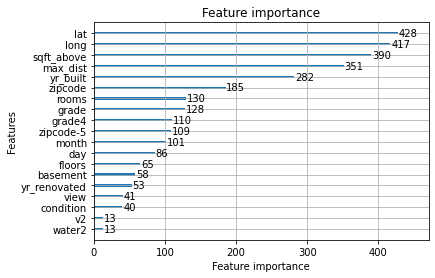
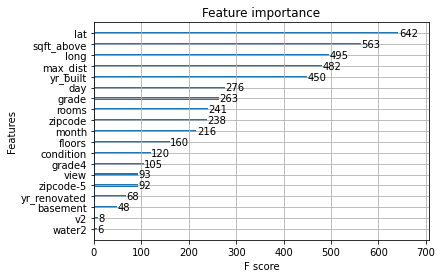

지금까지 가장 좋았던 성능의 처리로 lgbm, xgboost Feature importance를 실행한 결과 

In [333]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,grade4,day,water2,max_dist,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,grade4,day,water2,max_dist,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 131542.92655933465}

max_distance를 로그처리 해준결과 성능이 조금 더 좋아졌다. 또한 위의 feature importance 그림에서 long lat의 중요도가 매우 높으므로 이를 더 활용할 수 없을까 고민하다가 비율로 cut해줘서 사용해 보고자 한다.

In [357]:
experiment(pd.read_csv(train_data_path))

preprocessing
training
predicting
estimating
+:zipcode-5,basement,day,grade4,water2,lat2,max_dist,long2,rooms,area,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date


{'+:zipcode-5,basement,grade4,day,water2,max_dist,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 131542.92655933465,
 '+:zipcode-5,basement,grade4,day,water2,lat2,max_dist,long2,rooms,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132325.84798900093,
 '+:zipcode-5,basement,grade4,day,water2,max_dist,rooms,area,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132563.71882650294,
 '+:zipcode-5,basement,day,grade4,water2,lat2,max_dist,long2,rooms,area,month,v2,grade2 -:sqft_living15,bathrooms,sqft_lot,price,waterfront,bedrooms,id,sqft_lot15,sqft_living,sqft_basement,date': 132725.04282858883}

### 전체 전처리과정, test에도 적용

In [749]:
def haversine_array(lat1, lng1, lat2, lng2): 
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) 
    AVG_EARTH_RADIUS = 6371 # in km 
    lat = lat2 - lat1 
    lng = lng2 - lng1 
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2 
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)) 
    return h

def preprocess(df):
    df['date'] = df['date'].apply(lambda i: i[:6]).astype(int)
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['day'] = pd.to_datetime(df['date']).dt.day
    
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    df = df.astype('float64')
    df = df.astype({'bedrooms':'int', 'floors':'int','waterfront':'int',
                      'view':'int', 'condition':'int', 'grade':'int','month':'int','zipcode':'str','day':'int','year':'int'})
    skew_columns = ['sqft_living', 'sqft_lot', 'sqft_lot15', 'sqft_living15']
    
    coord = df[['lat','long']]
    pca = PCA(n_components=2)
    pca.fit(coord)
    coord_pca = pca.transform(coord)
    df['coord_pca1'] = coord_pca[:, 0]
    df['coord_pca2'] = coord_pca[:, 1]
    
    for c in skew_columns:
        df[c] = np.log1p(df[c].values)
    
    df['living/lot'] = df['sqft_living'] / df['sqft_lot']
    df['living/lot15'] = df['sqft_living15'] / df['sqft_lot15']
    df['renovated'] = np.where(df['yr_renovated']==0,0,1)
    
    # df['built'] = 2019 - df['yr_built']
    df['yr_built'] = np.log1p(df['yr_built'])
    # df['CCD'] = pd.cut(df['built'], bins=[0, 20, 40, 60, 120], labels=[1,2,3,4])
    
    df['waterfront'] = np.where(df['waterfront']==1, 3, 1)
    df['zipcode-4'] = 'z_' + df['zipcode'].str[3:4]
    df['zipcode-5'] = 'z_' + df['zipcode'].str[4:5]
    #df['zipcode-34'] = 'z_' + df['zipcode'].str[2:4]
    #df['zipcode-45'] = 'z_' + df['zipcode'].str[3:5]
    #df['zipcode-35'] = 'z_' + df['zipcode'].str[2:3] + df['zipcode'].str[4:5]
    x1,y1 = df['lat'].median(), df['long'].median()
    df['max_dist'] = np.log1p(haversine_array(df['lat'],df['long'],x1,y1))
    df['basement'] = np.where(df['sqft_basement']==0,0,1)
    df['rooms'] = df['bedrooms'] + df['bathrooms']
    df['water2'] = np.where(df['waterfront']==1,3,1)
    df['v2'] = df['view'] * df['water2']
    
    df['sqft_above'] = np.log1p(df['sqft_above'])
    df['long2'] = pd.qcut(df['long'],20,labels=False)
    df['lat2'] = pd.qcut(df['lat'],20,labels=False)
    df['area'] = df['long2'] + df['lat2']
    
    #  grade pooling
    df['grade2'] = np.where(df['grade'] < 7, 1,
                           (np.where(df['grade'] > 8, 3, 2)))
    df['grade3'] = df['grade2'] + df['condition']
    df['grade4'] = df['v2'] + df['grade3']
    
    #df = df.astype({'long2':str, 'lat2':str,'area':str, 'basement': str})
    df = df.astype({'basement': str,'zipcode':'float64','long2':str, 'lat2':str,'area':str,
                    'renovated':str})#,'CCD':str})
    
    del df['id']
    del df['date']
    del df['sqft_basement']
    del df['bedrooms'], df['bathrooms']
    del df['grade3']
    #del df['sqft_living15'],df['sqft_lot15']
    #del df['sqft_living'],df['sqft_lot']
    del df['long2'] , df['lat2']
    del df['year']
    del df['water2']
    #del df['yr_renovated']
    return df

In [750]:
def preprocess2(df):
    del df['sqft_total_size']
    return df

In [751]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train = preprocess(train)
test = preprocess(test)

In [752]:
train['per_price'] = train['price']/train['sqft_total_size']
zipcode_price = train.groupby('zipcode')['per_price'].agg({'median','var'}).reset_index()
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')
del train['per_price']

a=train['median'].mean()
b=train['var'].mean()
train['median'] = train['median'] - a
test['var'] = test['var'] - b
train['median'] = train['median'] - a
test['var'] = test['var'] - b

In [753]:
train['long'] = train['long'] - np.median(train['long'])
train['lat'] = train['lat'] - np.median(train['lat'])
test['long'] = test['long'] - np.median(train['long'])
test['lat'] = test['lat'] - np.median(train['lat'])

In [754]:
cat_cols = train.select_dtypes(exclude = np.number).columns
cat_cols

Index(['renovated', 'zipcode-4', 'zipcode-5', 'basement', 'area'], dtype='object')

In [755]:
train = preprocess2(train)
test = preprocess2(test)
train, test, _, _ = label_encode(train, test)
y = np.log1p(train['price'])
del train['price']
train.head()

,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,...,zipcode-5,max_dist,basement,rooms,v2,area,grade2,grade4,median,var
0,7.074117,8.639588,1,1,0,3,7,7.074117,7.578657,0.0,...,8,2.082690,0,4.00,0,7,2,5,-62.936902,95.089304
1,6.647688,9.210440,1,1,0,3,6,6.647688,7.567346,0.0,...,8,2.968308,0,3.00,0,20,1,4,-58.165085,175.554791
2,7.427144,8.997271,1,1,0,3,8,7.427144,7.594884,0.0,...,4,2.760911,0,5.00,0,21,2,5,-47.697043,380.571816
3,7.447751,8.827615,2,1,0,3,7,7.447751,7.598900,0.0,...,3,3.435146,0,5.25,0,34,2,5,-68.572653,55.868114
4,6.966967,9.181118,1,1,0,3,7,6.966967,7.582738,0.0,...,8,3.002172,0,4.50,0,37,2,5,-66.562386,102.044060


In [756]:
test.head()

,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,...,zipcode-5,max_dist,basement,rooms,v2,area,grade2,grade4,median,var
0,7.852050,8.887791,2,1,0,3,7,7.682943,7.576610,1991.0,...,5,2.937672,1,5.25,0,15,2,5,41.261931,-400.027171
1,7.581210,8.517393,1,1,0,5,7,6.957497,7.583756,0.0,...,6,2.678894,1,7.00,0,36,2,7,60.089974,-226.800031
2,8.598036,11.532051,1,1,0,3,11,8.266421,7.601902,0.0,...,3,3.006234,1,8.50,0,25,3,6,49.450121,-115.409526
3,7.484930,8.918784,1,1,0,3,7,6.957497,7.581210,0.0,...,6,2.441341,1,4.00,0,2,2,5,28.034710,-526.221395
4,7.544861,8.788898,2,1,0,3,7,7.544861,7.602900,0.0,...,8,3.336015,0,5.50,0,11,2,5,30.222582,-556.687708


In [757]:
train.shape, test.shape

((15035, 33), (6468, 33))

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [758]:
random_state=2020

# gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)
# ridge =  Ridge(random_state=random_state)
# lasso =  Lasso(random_state=random_state)
# models =[gboost,xgboost,lightgbm, rdforest,ridge,lasso]
models =[xgboost,lightgbm]

In [759]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [760]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.23)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df
    
get_scores(models, train, y)

,RMSE
LGBMRegressor,109962.619164
XGBRegressor,108395.718193


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

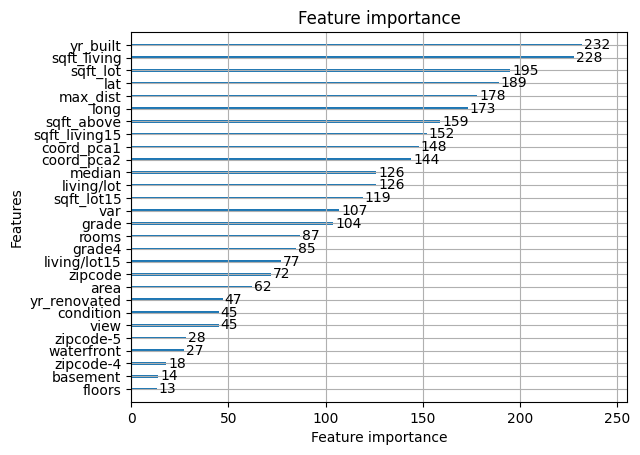

In [761]:
lplot(lightgbm)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

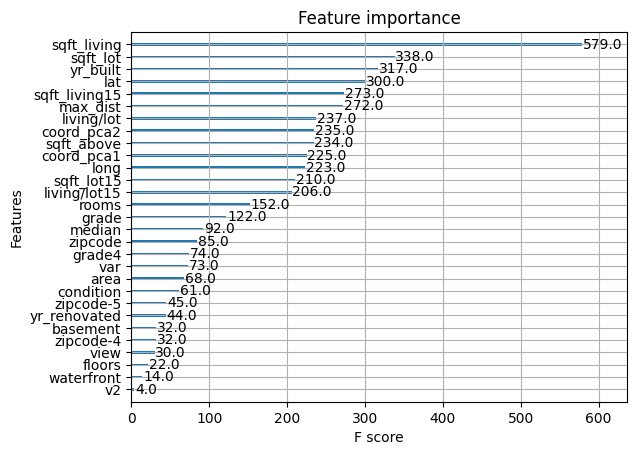

In [762]:
xplot(xgboost)

### Grid Search
그리드 서치로 파라미터 튜닝 진행

GridSearch for boosting

In [167]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSE')

    return results

In [40]:
models = [xgboost,lightgbm]
param_grid = {
    'n_estimators': [100],
    'max_depth': [8, 10],
    'learning_rate': [0.07, 0.01],
    #'sample_rate' : [0.5, 0.8, 1.0]
}

for model in models:
    results = my_GridSearch(model, train, y, param_grid)
    results = results.sort_values('RMSE')
    print(results)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

   learning_rate  max_depth  n_estimators      score      RMSE
1           0.07         10           100  -0.027496  0.165820
0           0.07          8           100  -0.027797  0.166725
2           0.01          8           100 -21.217630  4.606260
3           0.01         10           100 -21.217630  4.606260
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   learning_rate  max_depth  n_estimators     score      RMSE
1           0.07         10           100 -0.027938  0.167146
0           0.07          8           100 -0.028119  0.167687
3           0.01         10           100 -0.080485  0.283700
2           0.01          8           100 -0.080513  0.283749


GridSearch for randomforest

In [63]:
param_grid = {
    'n_estimators': [100,150,200],
    'max_depth' :[15,20],
    'max_samples' :[0.4],
    'max_features' :[1.0],

}


results = my_GridSearch(rdforest, train, y, param_grid)
results = results.sort_values('RMSE')
print(results)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
   max_depth  max_features  max_samples  n_estimators     score      RMSE
5         20           1.0          0.4           200 -0.032142  0.179281
4         20           1.0          0.4           150 -0.032205  0.179458
3         20           1.0          0.4           100 -0.032261  0.179614
2         15           1.0          0.4           200 -0.032329  0.179804
1         15           1.0          0.4           150 -0.032379  0.179942
0         15           1.0          0.4           100 -0.032490  0.180249


GridSearch for Lasso, Ridge

In [138]:
models = [lasso, ridge]
param_grid = {
    'alpha': [1e-3, 1e-2], 
    #'normalize': [True], 
    'max_iter': [1e7,1e8],

}


for model in models:
    results = my_GridSearch(model, train, y, param_grid)
    results = results.sort_values('RMSE')
    print(results)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   alpha     max_iter     score      RMSE
0  0.001   10000000.0 -0.059536  0.244000
1  0.001  100000000.0 -0.059536  0.244000
2  0.010   10000000.0 -0.069862  0.264315
3  0.010  100000000.0 -0.069862  0.264315
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.3; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.7; total time=   0.1s
[CV] END ............................................alpha=1; total time=   0.1s
[CV] END ............................................alpha=1; total time=   0.1s
[CV] END .............

### Make Submission

훈련 데이터셋으로 4개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [763]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state, max_depth=8, n_estimators=100,
                                  learning_rate=0.07)
xgb = XGBRegressor(random_state=random_state, max_depth=10, n_estimators=100,
                      learning_rate=0.07)
lgbm = LGBMRegressor(random_state=random_state, max_depth=10, n_estimators=100,
                        learning_rate=0.07)
rdforest = RandomForestRegressor(random_state=random_state, max_depth=20, n_estimators=200,
                                max_samples=0.4,max_features=1.0)

# models =[gboost, xgboost, lightgbm, rdforest]
# models = [xgboost, lightgbm, gboost]
models =[xgb, lgbm]
#models =[xgboost]

In [764]:
def AveragingBlending(models, x_train, y, x_test):
    for m in models : 
        m.fit(x_train.values, y)

    predictions = np.column_stack([ 
        np.expm1(m.predict(x_test.values)) for m in models
    ])
    return np.mean(predictions, axis=1)#predictions

In [765]:
y_pred = AveragingBlending(models, train, y, test)

In [766]:
y_pred

array([ 640667.29993437,  465665.53787059, 1871869.77245476, ...,
        337972.07509034,  290045.28803945,  462602.38634524])

In [767]:
# def save_submission(model, train, y, test, model_name, rmse=None):
#     model.fit(train, y)
#     prediction = model.predict(test)
#     data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
#     submission_path = join(data_dir, 'sample_submission.csv')
#     submission = pd.read_csv(submission_path)
#     submission['price'] = prediction
#     submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, model_name, rmse)
#     submission.to_csv(submission_csv_path, index=False)
#     print('{} saved!'.format(submission_csv_path))

In [768]:
def save_submission(prediction, txt = '1'):
    data_dir = os.getcwd() + '\\submission'
    submission_path = 'sample_submission.csv'
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/{}.csv'.format(data_dir, txt)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [769]:
save_submission(y_pred, 'lelel')

c:\Users\이정진\Desktop\Aiffel\Exploration\submission/lelel.csv saved!


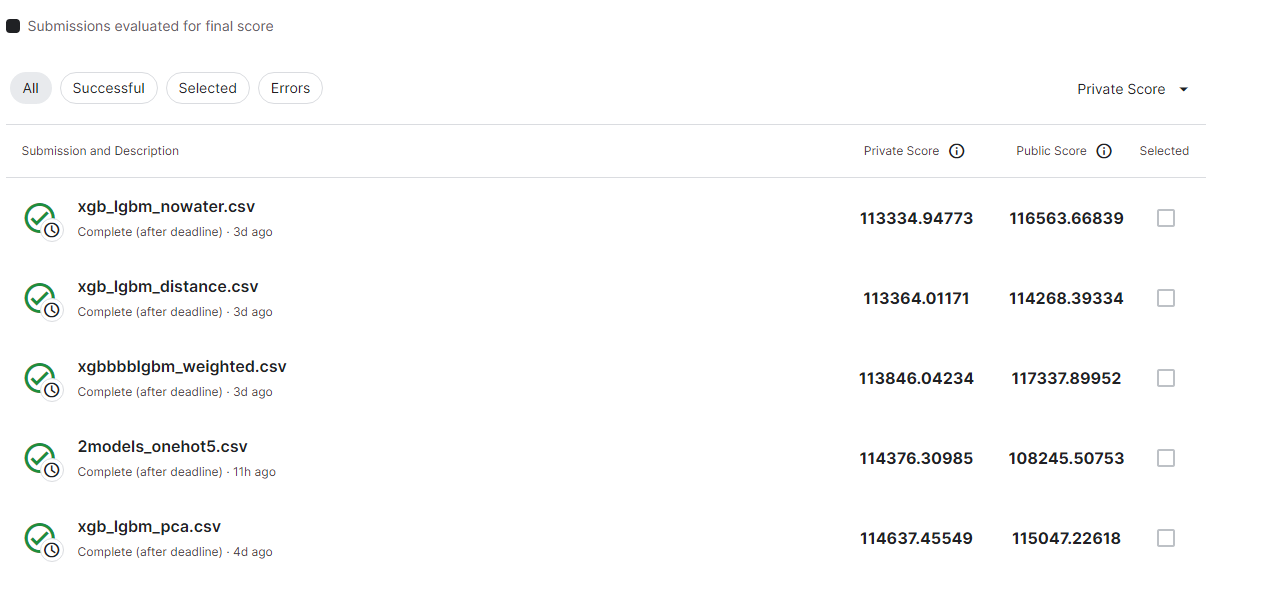

11만점을 넘기지 못했습니다.